In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# File paths
boston_ev_count_path = 'BostonEVCount_new.xlsx'
battery_size_data_path = 'BatterySizeData.xlsx'
charging_profile_path = 'ChargingProfileBoston.xlsx'
shapefile_path = 'ZIPCODES_Boston.shp'

# Constants
CHARGING_INTERVAL_MINUTES = 10
TIME_INTERVAL_HOURS = CHARGING_INTERVAL_MINUTES / 60
NUM_INTERVALS = 24 * 60 // CHARGING_INTERVAL_MINUTES
CHARGING_LOAD = 7  # kW

# Load datasets
def load_data():
    return (
        pd.read_excel(boston_ev_count_path),
        pd.read_excel(battery_size_data_path),
        pd.read_excel(charging_profile_path)
    )

# Preprocess data
def preprocess_data(boston_ev_count_df, battery_size_data_df):
    merged_df = (
        pd.melt(boston_ev_count_df, id_vars=['Zip Code'], var_name='Car Name', value_name='Count')
        .dropna(subset=['Count'])
        .query("Count > 0")
        .merge(battery_size_data_df, on='Car Name', how='left')
    )
    merged_df['Count'] = merged_df['Count'].astype(int)
    merged_df['Battery Size'] = pd.to_numeric(merged_df['Battery Size'], errors='coerce')
    merged_df['Zip Code'] = merged_df['Zip Code'].astype(str).str.zfill(5)
    return merged_df

# Calculate charging load profile
def calculate_charging_load_profile(car_count, battery_size_kwh, probabilities):
    num_intervals = len(probabilities)
    # Energy added in one full 10-minute interval at 7 kW (in kWh)
    energy_per_interval = CHARGING_LOAD * TIME_INTERVAL_HOURS  
    profile = np.zeros(num_intervals)
    cumulative_energy = 0.0  # Energy charged per car so far (kWh)
    
    for t in range(num_intervals):
        if cumulative_energy < battery_size_kwh:
            # Check if a full interval would exceed the battery capacity.
            if cumulative_energy + energy_per_interval > battery_size_kwh:
                # Only the remaining energy is needed; adjust the effective power.
                effective_load = (battery_size_kwh - cumulative_energy) / TIME_INTERVAL_HOURS
            else:
                effective_load = CHARGING_LOAD
            
            # In this interval the expected load (in kW) is the effective power times the probability.
            profile[t] = effective_load * probabilities[t]
            
            # Update the cumulative energy (expected energy added in kWh).
            cumulative_energy += energy_per_interval * probabilities[t]
        else:
            profile[t] = 0.0  # No charging once the battery is full.
    
    # Multiply the per-car profile by the total number of cars.
    return car_count * profile

# Generate charging load profiles
def generate_charging_load_profiles(merged_df, probabilities):
    profiles = {}
    for _, row in merged_df.iterrows():
        zip_code = row['Zip Code']
        car_count = row['Count']
        battery_size_kwh = row['Battery Size']
        if zip_code not in profiles:
            profiles[zip_code] = np.zeros(NUM_INTERVALS)
        profiles[zip_code] += calculate_charging_load_profile(car_count, battery_size_kwh, probabilities)
    return profiles

# Save profiles to Excel
def save_profiles_to_excel(profiles, file_name):
    time_labels = [f"{h:02}:{m:02}" for h in range(24) for m in range(0, 60, CHARGING_INTERVAL_MINUTES)]
    profiles_df = pd.DataFrame.from_dict(profiles, orient='index', columns=time_labels)
    profiles_df.index.name = 'Zip Code'
    profiles_df.to_excel(file_name)
    print(f"Charging load profiles saved to {file_name}")

# Plot charging load profile for a ZIP code
def plot_zip_code_charging(profiles, zip_code):
    if zip_code not in profiles:
        print(f"ZIP Code {zip_code} not found.")
        return
    time_labels = [f"{h:02}:{m:02}" for h in range(24) for m in range(0, 60, CHARGING_INTERVAL_MINUTES)]
    plt.figure(figsize=(16, 8))
    plt.plot(time_labels, profiles[zip_code], label=f'ZIP Code {zip_code}', linewidth=2)
    plt.xticks(range(0, len(time_labels), 6), time_labels[::6], rotation=45, fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(f'Charging Load Pattern for ZIP Code {zip_code}', fontsize=18)
    plt.ylabel('Charging Load (kW)', fontsize=18)
    plt.legend(fontsize=18)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Generate geospatial heatmap
def generate_heatmap(profiles, shapefile_path):
    boston_zip_shape = gpd.read_file(shapefile_path).to_crs(epsg=26986)
    boston_zip_shape['Zip Code'] = boston_zip_shape['POSTCODE'].astype(str)
    avg_charging_load = {zip_code: np.max(profile) for zip_code, profile in profiles.items()}
    heatmap_df = pd.DataFrame(list(avg_charging_load.items()), columns=['Zip Code', 'Average Charging Load (kW)'])
    heatmap_gdf = boston_zip_shape.merge(heatmap_df, on='Zip Code', how='left')
    heatmap_gdf['geometry'] = heatmap_gdf['geometry'].simplify(tolerance=0.01)

    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap_gdf.boundary.plot(ax=ax, linewidth=1, color='grey')
    heatmap_gdf.plot(
        column='Average Charging Load (kW)', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8',
        legend=True, legend_kwds={'shrink': 0.7, 'label': 'Charging Load during Peak Hours (kW)'}
    )
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Plot total charging load profile in MW
def plot_total_charging_load_profile(profiles):
    total_charging_load_profile = sum(profiles.values()) / 1000  # Convert kW to MW
    time_labels = [f"{h:02}:{m:02}" for h in range(24) for m in range(0, 60, CHARGING_INTERVAL_MINUTES)]
    plt.figure(figsize=(16, 8))
    plt.plot(range(NUM_INTERVALS), total_charging_load_profile, color='red', linewidth=2)
    peak_idx = np.argmax(total_charging_load_profile)
    peak_value = total_charging_load_profile[peak_idx]
    plt.annotate(
        f'Peak: {peak_value:.2f} MW',
        xy=(peak_idx, peak_value),
        xytext=(peak_idx + 10, peak_value + 0.5),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        fontsize=18
    )
    plt.xticks(range(0, NUM_INTERVALS, 6), time_labels[::6], rotation=45, fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Charging Load (MW)', fontsize=18)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot charging load profiles for each ZIP code
def plot_all_zip_codes(profiles):
    charging_profile_df_list = []
    for zip_code, charging_load_profile in profiles.items():
        for t in range(NUM_INTERVALS):
            charging_profile_df_list.append({
                'Zip Code': zip_code,
                'Hour of Day': t * TIME_INTERVAL_HOURS,
                'Charging Load (kW)': charging_load_profile[t]
            })
    charging_profile_df = pd.DataFrame(charging_profile_df_list)

    plt.figure(figsize=(20, 12))
    sns.set(style="whitegrid")
    g = sns.FacetGrid(charging_profile_df, col="Zip Code", col_wrap=7, height=2.5)
    g.map_dataframe(sns.lineplot, x="Hour of Day", y="Charging Load (kW)", color="purple")
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Hour", "Charging Load (kW)")
    plt.subplots_adjust(top=0.9)
    plt.show()

Charging load profiles saved to optimized_charging_load_profiles.xlsx


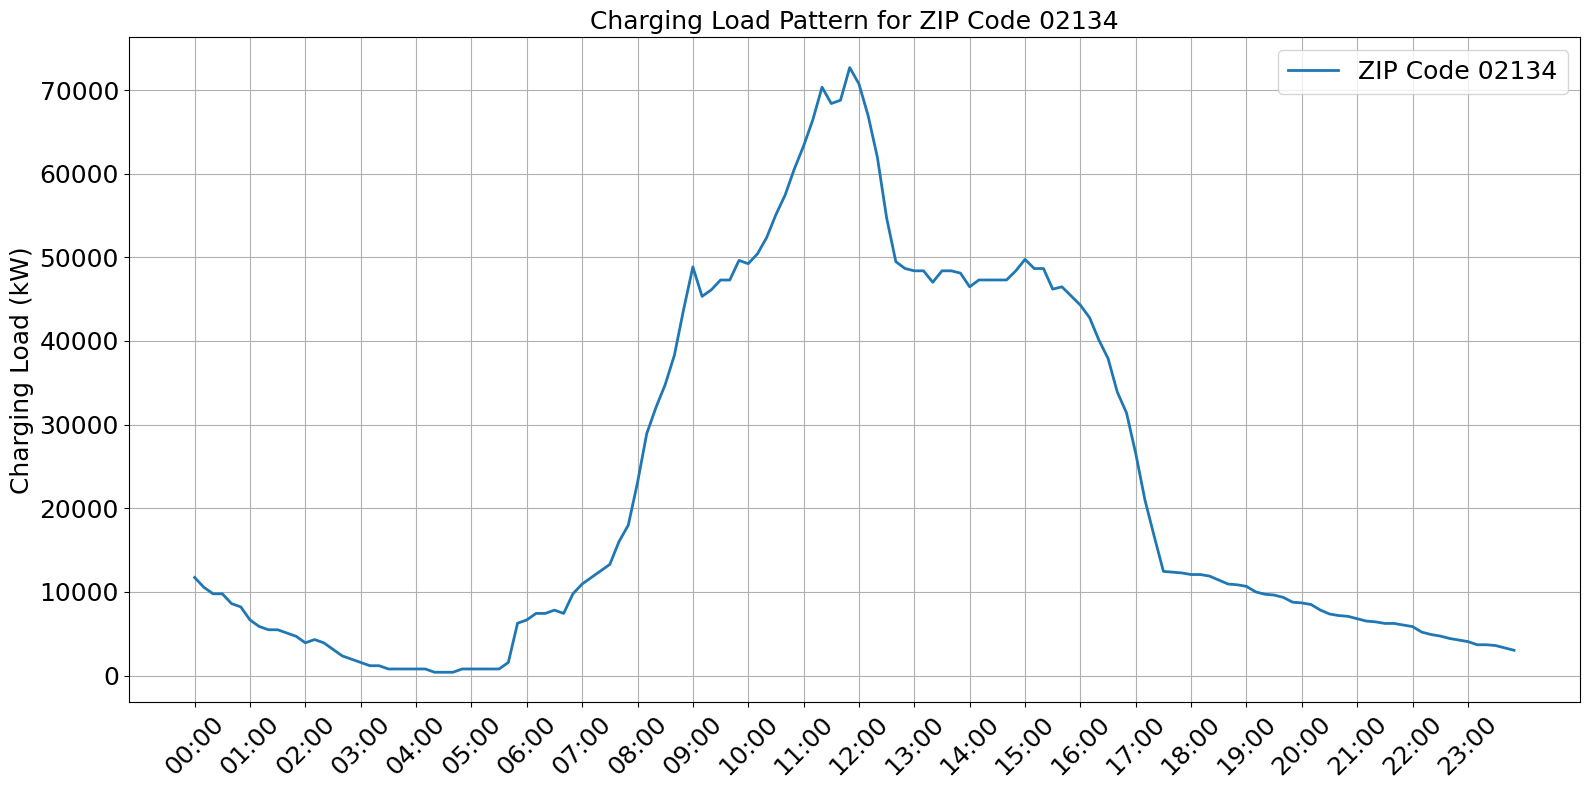

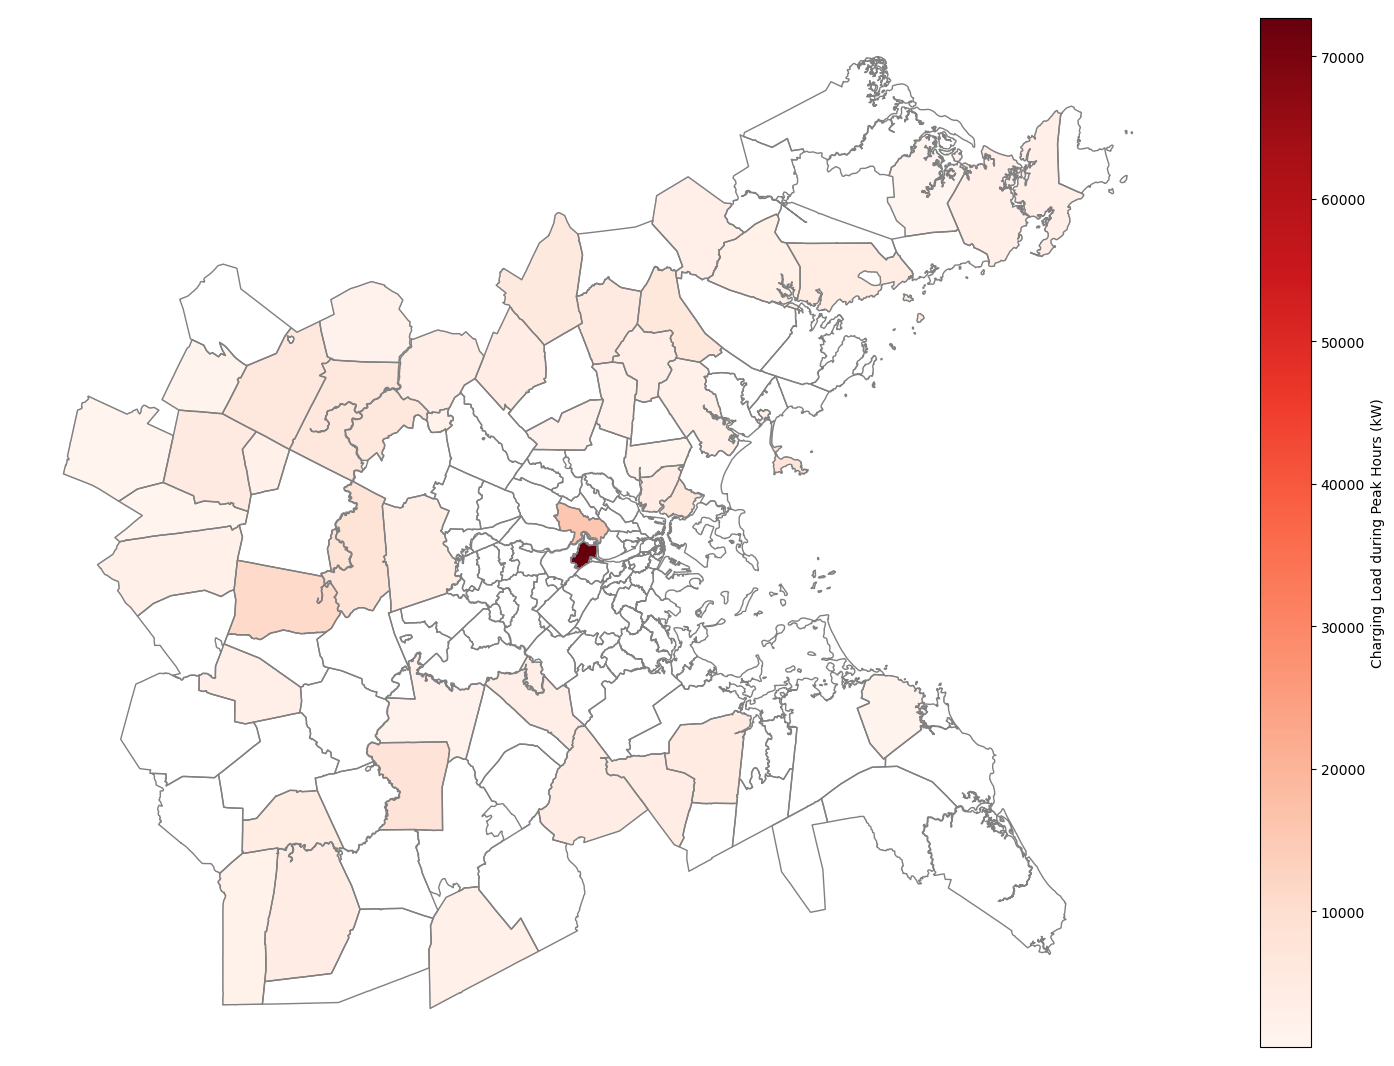

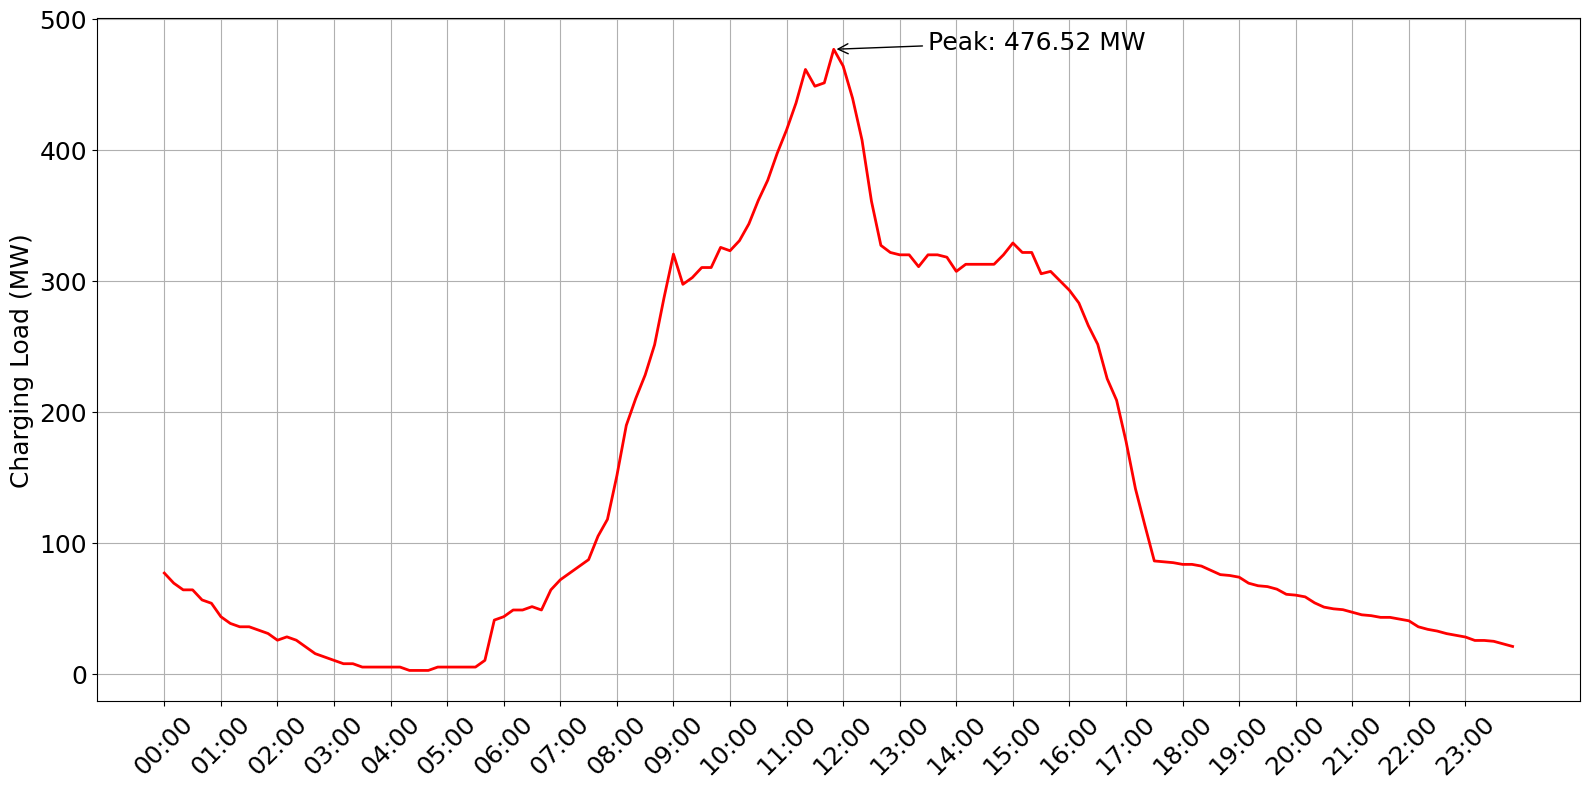

<Figure size 2000x1200 with 0 Axes>

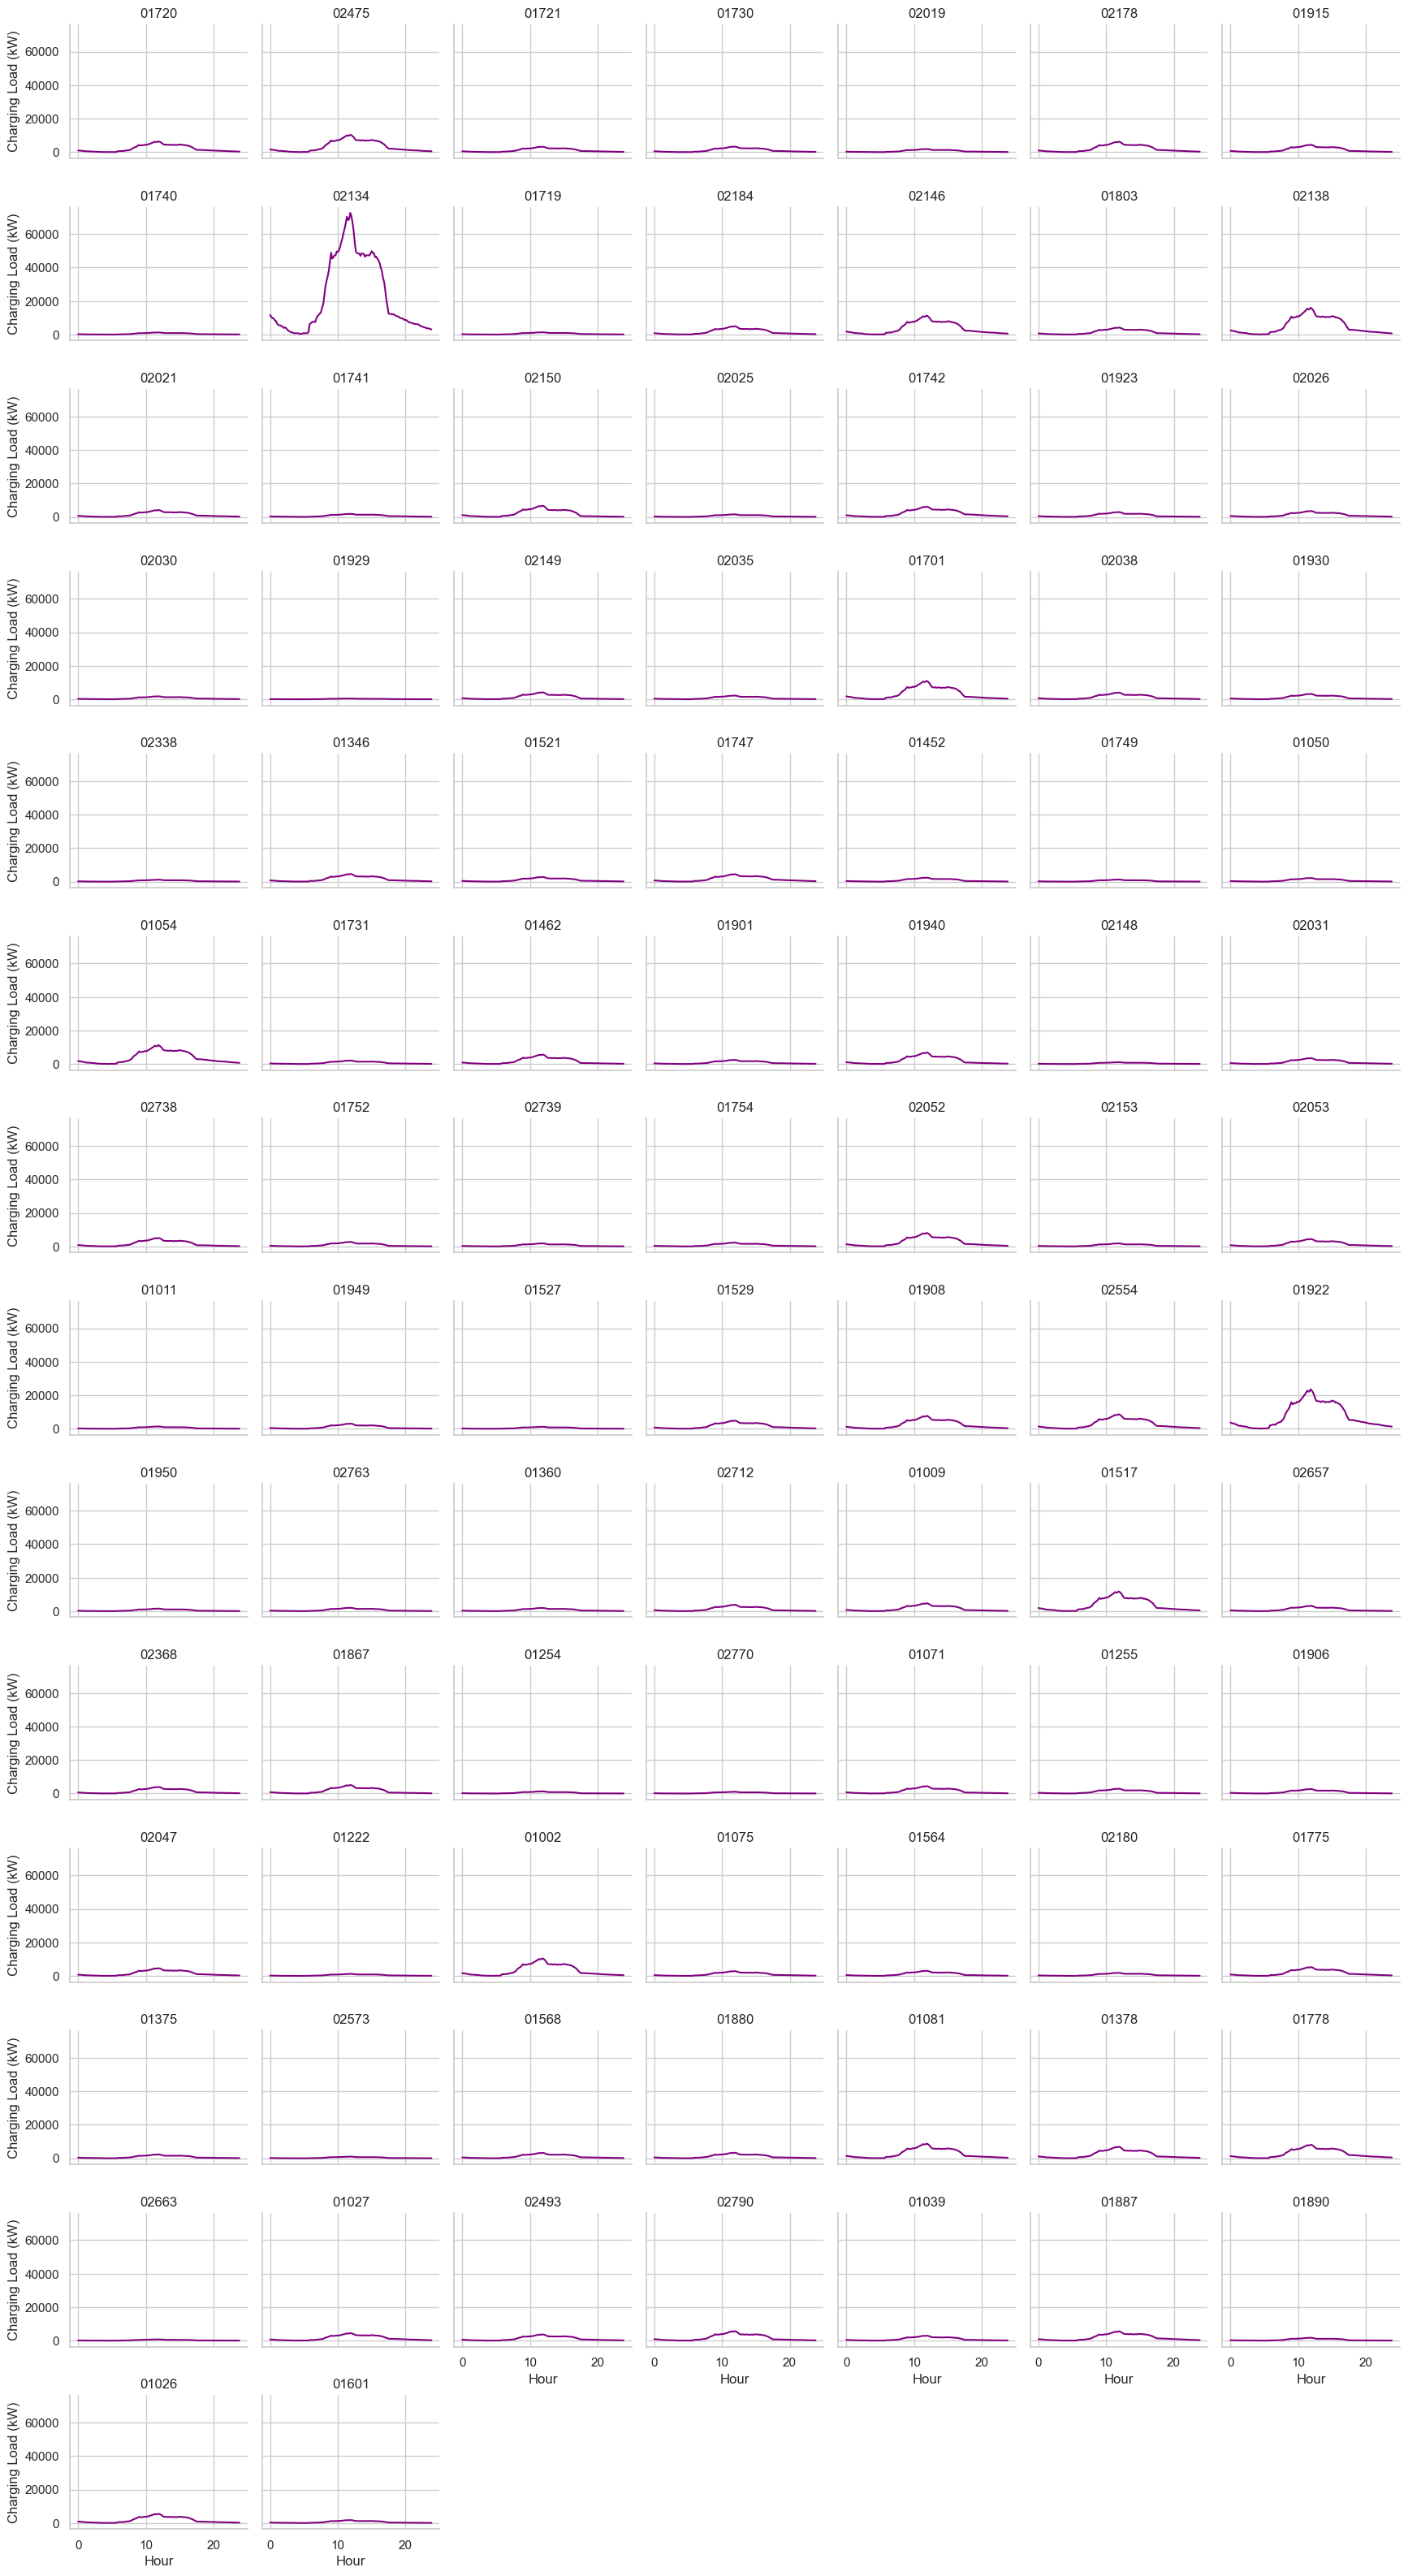

In [2]:
boston_ev_count_df, battery_size_data_df, charging_profile_df = load_data()
merged_df = preprocess_data(boston_ev_count_df, battery_size_data_df)
charging_probabilities = np.resize(charging_profile_df['Probability'].values, NUM_INTERVALS)
charging_load_profiles = generate_charging_load_profiles(merged_df, charging_probabilities)
save_profiles_to_excel(charging_load_profiles, 'optimized_charging_load_profiles.xlsx')
plot_zip_code_charging(charging_load_profiles, '02134')
generate_heatmap(charging_load_profiles, shapefile_path)
plot_total_charging_load_profile(charging_load_profiles)
plot_all_zip_codes(charging_load_profiles)